In [39]:
from ase.io.espresso import read_espresso_in
from mattersim.forcefield.potential import MatterSimCalculator
import torch
import numpy as np
from mattersim.applications.relax import Relaxer
from mattersim.applications.phonon import PhononWorkflow
from ase.build import bulk, make_supercell
from ase import Atom

      Step     Time          Energy          fmax
BFGS:    0 13:57:17      -31.636757        0.290940
BFGS:    1 13:57:17      -31.635687        0.458326
BFGS:    2 13:57:18      -31.637449        0.003686
BFGS:    3 13:57:18      -31.637451        0.000043
Atoms(symbols='SnO3Ba', pbc=True, cell=[[4.18665986537205, 3.925357928264837e-33, -1.7670002785437362e-35], [5.885875644934183e-33, 4.18665986537205, -7.769604698747367e-21], [-3.1593095485194385e-33, -7.769604698745399e-21, 4.18665986537205]], initial_magmoms=..., calculator=MatterSimCalculator(...))
Supercell matrix for 2nd force constants : 
[[2 0 0]
 [0 2 0]
 [0 0 2]]


Inferring forces for displaced atoms and computing fcs ...


100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


Max drift of force constants: -1.38654916 (yy) -0.00123742 (zz) 
Max drift after traditional symmetrization: -0.00000000 (zz) -0.00000000 (zz) 
Qpoints mesh for Brillouin Zone integration : [12 12 12]
Dispersion relations using phonopy for SnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3Ba ...



c:\Users\rual\AppData\Local\anaconda3\envs\mattersim\Lib\site-packages\seekpath\hpkot\__init__.py:172: DeprecationWarning: dict interface is deprecated. Use attribute interface instead
  conv_lattice = dataset["std_lattice"]


Has imaginary phonon: False
Phonon frequencies: <phonopy.api_phonopy.Phonopy object at 0x000001F6A4166490>
Enthalpy: 90.29688653014739


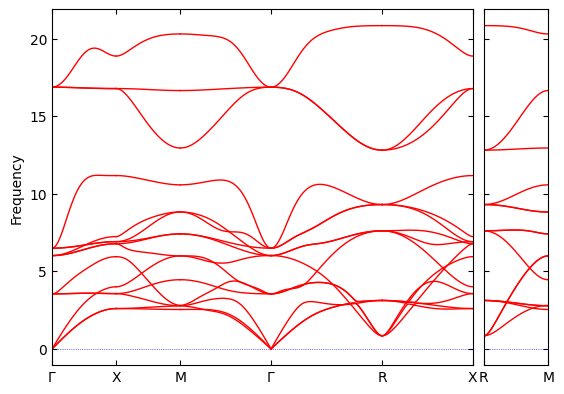

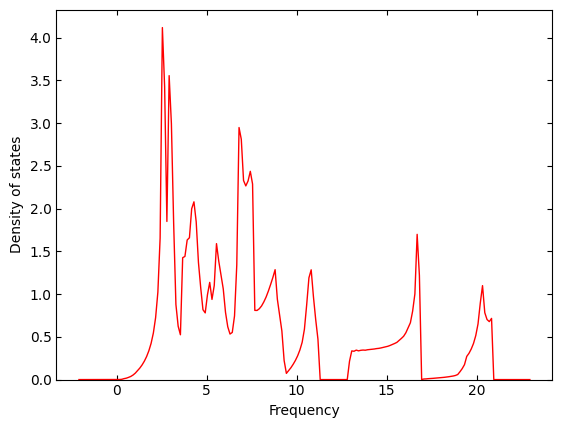

In [37]:
with open("pw.basno3.vc-relax.in", 'r') as in_file:
    bso = read_espresso_in(in_file)


device = "cuda" if torch.cuda.is_available() else "cpu"
bso.calc = MatterSimCalculator(load_path="MatterSim-v1.0.0-5M.pth", device=device)
# initialize the relaxation object
relaxer = Relaxer(
    optimizer="BFGS", # the optimization method
    filter="ExpCellFilter", # filter to apply to the cell
    constrain_symmetry=True, # whether to constrain the symmetry
)

relaxer.relax(bso, steps=500, fmax=0.0001)
#relaxer.relax(super_bso, steps=500, fmax=0.0001)
print(bso)

super_bso = make_supercell(bso, np.diag([2,2,2]))
super_bso.calc = bso.calc

ph = PhononWorkflow(
    atoms=super_bso,
    find_prim = False,
    work_dir = "./tmp/phonon_bso",
    amplitude = 0.001,
    supercell_matrix = np.diag([2,2,2]),
)

has_imag, phonons = ph.run()
print(f"Has imaginary phonon: {has_imag}")
print(f"Phonon frequencies: {phonons}")

phonons.run_thermal_properties(t_step=100, t_max=700)
temperatures = phonons.get_thermal_properties_dict()["temperatures"]
free_energy = phonons.get_thermal_properties_dict()["free_energy"]
entropy = phonons.get_thermal_properties_dict()["entropy"]
enthalpy = free_energy + entropy / 1000 * temperatures
print("Enthalpy:", enthalpy[-1])


In [118]:
init = make_supercell(bso, np.diag([1,1,1]))
init.calc = bso.calc
# Add one hydrogen atom to the cell
# Add the hydrogen atom at the center
init.append(Atom('H', [2.0933,0.0,0.9]))
init.edit()

Supercell matrix for 2nd force constants : 
[[2 0 0]
 [0 2 0]
 [0 0 2]]


Inferring forces for displaced atoms and computing fcs ...


100%|██████████| 148/148 [04:41<00:00,  1.90s/it]


Max drift of force constants: 0.57957883 (xx) -0.00412177 (zx) 
Max drift after traditional symmetrization: -0.00000000 (zz) -0.00000000 (zz) 
Qpoints mesh for Brillouin Zone integration : [12 12 12]
Dispersion relations using phonopy for SnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaH ...



c:\Users\rual\AppData\Local\anaconda3\envs\mattersim\Lib\site-packages\seekpath\hpkot\__init__.py:172: DeprecationWarning: dict interface is deprecated. Use attribute interface instead
  conv_lattice = dataset["std_lattice"]


Warning! Imaginary frequencies found!
Has imaginary phonon: True
Phonon frequencies: <phonopy.api_phonopy.Phonopy object at 0x000001F6AE4DB110>
Enthalpy: 750.822699288573


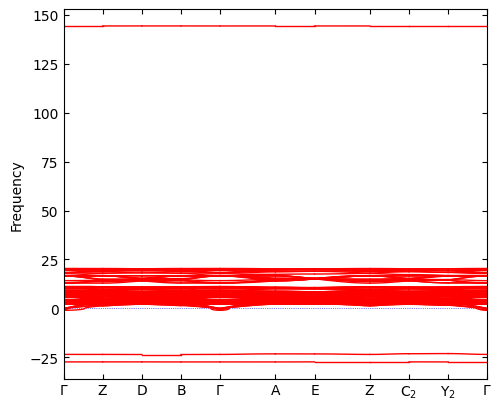

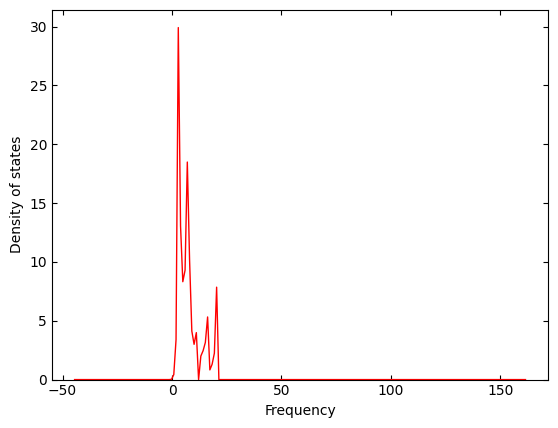

In [ ]:


ph = PhononWorkflow(
    atoms=super_bso_h_init,
    find_prim = False,
    work_dir = "./tmp/phonon_bso",
    amplitude = 0.0001,
    supercell_matrix = np.diag([3,3,3]),
)

has_imag, phonons = ph.run()
print(f"Has imaginary phonon: {has_imag}")
print(f"Phonon frequencies: {phonons}")

phonons.run_thermal_properties(t_step=100, t_max=700)
temperatures = phonons.get_thermal_properties_dict()["temperatures"]
free_energy = phonons.get_thermal_properties_dict()["free_energy"]
entropy = phonons.get_thermal_properties_dict()["entropy"]
enthalpy = free_energy + entropy / 1000 * temperatures
print("Enthalpy:", enthalpy[-1])

In [122]:
init = make_supercell(bso, np.diag([3,3,3]))
init.calc = bso.calc
# Add one hydrogen atom to the cell
# Add the hydrogen atom at the center
init.append(Atom('H', [2.0933,0.0,0.9]))

relaxer_fixed = Relaxer(
    optimizer="BFGS", # the optimization method
)
print(init)
relaxer_fixed.relax(init, steps=500, fmax=0.0001)
print(init)
init.edit()

Atoms(symbols='HBa27O81Sn27', pbc=True, cell=[12.55997959611615, 12.55997959611615, 12.55997959611615], initial_magmoms=..., calculator=MatterSimCalculator(...))
      Step     Time          Energy          fmax
BFGS:    0 18:26:32     -856.390259        4.735992
BFGS:    1 18:26:33     -857.060303        2.425175
BFGS:    2 18:26:35     -857.384949        1.479842
BFGS:    3 18:26:36     -857.519043        0.776134
BFGS:    4 18:26:37     -857.582520        0.630563
BFGS:    5 18:26:39     -857.620239        0.332765
BFGS:    6 18:26:40     -857.635925        0.372879
BFGS:    7 18:26:41     -857.650635        0.312895
BFGS:    8 18:26:43     -857.660522        0.251637
BFGS:    9 18:26:44     -857.667236        0.149375
BFGS:   10 18:26:46     -857.671814        0.146283
BFGS:   11 18:26:47     -857.677185        0.179054
BFGS:   12 18:26:48     -857.681763        0.139618
BFGS:   13 18:26:50     -857.685547        0.100027
BFGS:   14 18:26:51     -857.688110        0.087573
BFGS:   

Supercell matrix for 2nd force constants : 
[[1 0 0]
 [0 1 0]
 [0 0 1]]


Inferring forces for displaced atoms and computing fcs ...


100%|██████████| 242/242 [04:55<00:00,  1.22s/it]


Max drift of force constants: -0.44136532 (yy) -0.00153520 (yy) 
Max drift after traditional symmetrization: 0.00000000 (zz) 0.00000000 (zz) 
Qpoints mesh for Brillouin Zone integration : [6 6 6]
Dispersion relations using phonopy for SnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaH ...



c:\Users\rual\AppData\Local\anaconda3\envs\mattersim\Lib\site-packages\seekpath\hpkot\__init__.py:172: DeprecationWarning: dict interface is deprecated. Use attribute interface instead
  conv_lattice = dataset["std_lattice"]


Warning! Imaginary frequencies found!
Has imaginary phonon: True
Phonon frequencies: <phonopy.api_phonopy.Phonopy object at 0x000001F73EA0E490>


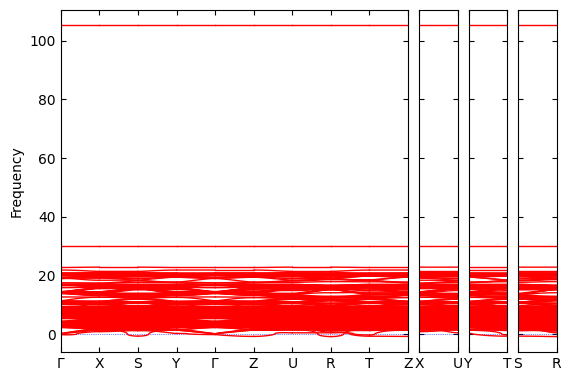

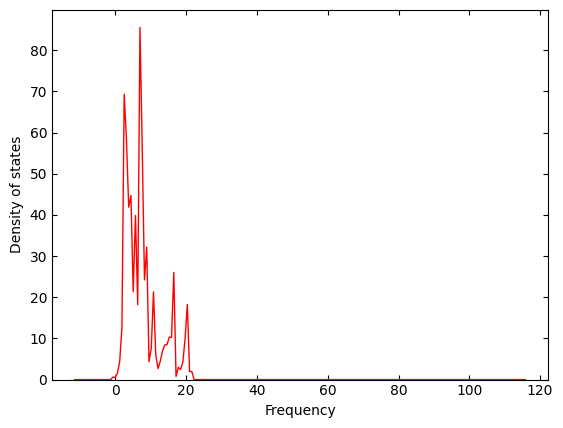

In [123]:

ph = PhononWorkflow(
    atoms=init,
    find_prim = False,
    work_dir = "./tmp/phonon_bso",
    amplitude = 0.001,
    supercell_matrix = np.diag([1,1,1]),
)

has_imag, phonons_init = ph.run()
print(f"Has imaginary phonon: {has_imag}")
print(f"Phonon frequencies: {phonons_init}")

In [124]:
fin = make_supercell(bso, np.diag([3,3,3]))
fin.calc = bso.calc
# Add one hydrogen atom to the cell
# Add the hydrogen atom at the center
fin.append(Atom('H', [0.9,0.0,2.0933]))
relaxer_fixed.relax(fin, steps=500, fmax=0.0001)

      Step     Time          Energy          fmax
BFGS:    0 18:49:53     -856.390259        4.735993
BFGS:    1 18:49:54     -857.060303        2.425174
BFGS:    2 18:49:56     -857.385132        1.479841
BFGS:    3 18:49:57     -857.519043        0.776135
BFGS:    4 18:49:59     -857.582397        0.630561
BFGS:    5 18:50:00     -857.620117        0.332765
BFGS:    6 18:50:01     -857.635681        0.372880
BFGS:    7 18:50:03     -857.650696        0.312889
BFGS:    8 18:50:04     -857.660156        0.251630
BFGS:    9 18:50:05     -857.667236        0.149378
BFGS:   10 18:50:07     -857.672058        0.146293
BFGS:   11 18:50:08     -857.677429        0.179055
BFGS:   12 18:50:09     -857.681946        0.139610
BFGS:   13 18:50:11     -857.685730        0.100031
BFGS:   14 18:50:12     -857.688049        0.087576
BFGS:   15 18:50:14     -857.690186        0.074079
BFGS:   16 18:50:15     -857.691833        0.089629
BFGS:   17 18:50:16     -857.693115        0.070173
BFGS:   18 18:

(True,
 Atoms(symbols='HBa27O81Sn27', pbc=True, cell=[12.55997959611615, 12.55997959611615, 12.55997959611615], initial_magmoms=..., calculator=MatterSimCalculator(...)))

In [131]:
from ase.mep import NEB
from ase.optimize import BFGS

n_images = 1
images = [init]
images += [init.copy() for i in range(n_images)]
images.append(fin)

neb = NEB(images, climb=True)
neb.interpolate()

for image in images:
    image.calc = MatterSimCalculator(load_path="MatterSim-v1.0.0-5M.pth", device=device)

optimizer = BFGS(neb)
optimizer.run(fmax=0.01)  # convergence criterion in eV/Å

      Step     Time          Energy          fmax
BFGS:    0 19:04:11     -856.478027        2.484703
BFGS:    1 19:04:12     -856.718628        2.227170
BFGS:    2 19:04:14     -857.305908        1.260352
BFGS:    3 19:04:15     -857.351807        0.535984
BFGS:    4 19:04:16     -857.371826        0.316393
BFGS:    5 19:04:18     -857.394592        0.265297
BFGS:    6 19:04:19     -857.408264        0.250620
BFGS:    7 19:04:20     -857.421082        0.226772
BFGS:    8 19:04:22     -857.430664        0.224220
BFGS:    9 19:04:23     -857.438843        0.165427
BFGS:   10 19:04:25     -857.443359        0.099843
BFGS:   11 19:04:26     -857.446411        0.080409
BFGS:   12 19:04:27     -857.449158        0.118502
BFGS:   13 19:04:29     -857.451538        0.127502
BFGS:   14 19:04:30     -857.454346        0.106286
BFGS:   15 19:04:31     -857.456421        0.097153
BFGS:   16 19:04:33     -857.457703        0.061002
BFGS:   17 19:04:34     -857.458923        0.060670
BFGS:   18 19:

np.True_

In [ ]:
print(neb)
for image in neb.images:
    print(image)

print(neb.images[1].get_potential_energy()-init.get_potential_energy())

Atoms(symbols='HBa27O81Sn27', pbc=True, cell=[12.55997959611615, 12.55997959611615, 12.55997959611615], initial_magmoms=..., calculator=MatterSimCalculator(...))
Atoms(symbols='HBa27O81Sn27', pbc=True, cell=[12.55997959611615, 12.55997959611615, 12.55997959611615], initial_magmoms=..., calculator=MatterSimCalculator(...))
Atoms(symbols='HBa27O81Sn27', pbc=True, cell=[12.55997959611615, 12.55997959611615, 12.55997959611615], initial_magmoms=..., calculator=MatterSimCalculator(...))
0.23828125


In [133]:
ts = neb.images[1]

Supercell matrix for 2nd force constants : 
[[1 0 0]
 [0 1 0]
 [0 0 1]]


Inferring forces for displaced atoms and computing fcs ...


100%|██████████| 236/236 [04:36<00:00,  1.17s/it]


Max drift of force constants: 0.12628442 (yy) 0.01293463 (yy) 
Max drift after traditional symmetrization: 0.00000000 (zz) 0.00000000 (zz) 
Qpoints mesh for Brillouin Zone integration : [6 6 6]
Dispersion relations using phonopy for SnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaSnO3BaH ...



c:\Users\rual\AppData\Local\anaconda3\envs\mattersim\Lib\site-packages\seekpath\hpkot\__init__.py:172: DeprecationWarning: dict interface is deprecated. Use attribute interface instead
  conv_lattice = dataset["std_lattice"]
c:\Users\rual\AppData\Local\anaconda3\envs\mattersim\Lib\site-packages\seekpath\hpkot\__init__.py:258: EdgeCaseWarning: oA lattice, but b almost equal to c
  warnings.warn("oA lattice, but b almost equal to c", EdgeCaseWarning)


Warning! Imaginary frequencies found!
Has imaginary phonon: True
Phonon frequencies: <phonopy.api_phonopy.Phonopy object at 0x000001F6B2C07ED0>


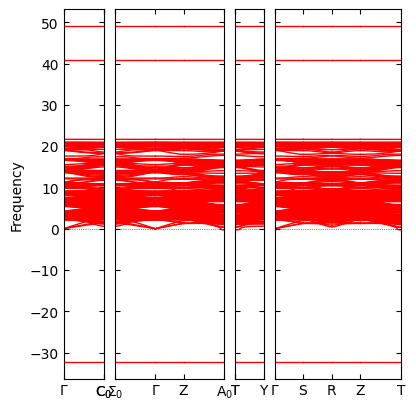

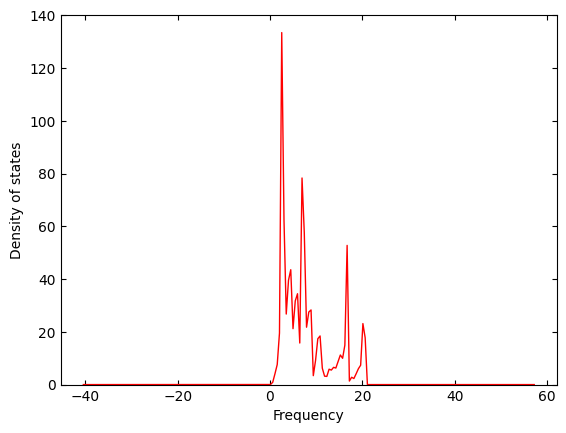

In [134]:

ph_ts = PhononWorkflow(
    atoms=ts,
    find_prim = False,
    work_dir = "./tmp/phonon_bso",
    amplitude = 0.0001,
    supercell_matrix = np.diag([1,1,1]),
)

has_imag, phonons_ts = ph_ts.run()
print(f"Has imaginary phonon: {has_imag}")
print(f"Phonon frequencies: {phonons_ts}")

Enthalpy TS: 2458.0458076563236
6210.235557745146
Enthalpy init: 2470.8148006885544
6224.405209553108


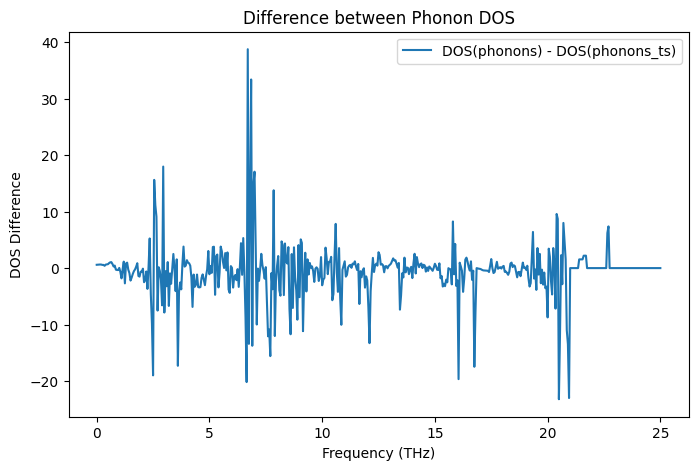

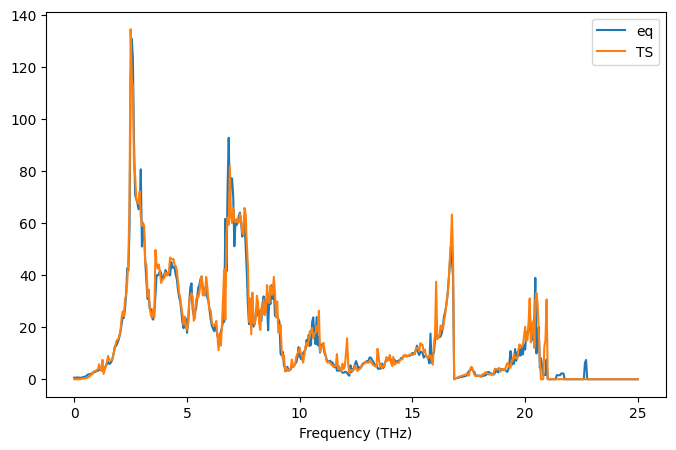

In [135]:
phonons_init.run_mesh([6,6,6])
phonons_ts.run_mesh([6,6,6])


# Calculate the difference between the phonon DOS of the initial and transition state structures
phonons_init.run_total_dos(freq_min=0, freq_max=25, freq_pitch=0.05)
phonons_ts.run_total_dos(freq_min=0, freq_max=25, freq_pitch=0.05)
# Get the phonon DOS for both
dos_phonons = phonons_init.get_total_dos_dict()
dos_phonons_ts = phonons_ts.get_total_dos_dict()

phonons_ts.run_thermal_properties(t_step=100, t_max=700)
temperatures = phonons_ts.get_thermal_properties_dict()["temperatures"]
free_energy = phonons_ts.get_thermal_properties_dict()["free_energy"]
entropy = phonons_ts.get_thermal_properties_dict()["entropy"]
enthalpy_ts = free_energy + entropy / 1000 * temperatures
print("Enthalpy TS:", enthalpy_ts[-1])
print(entropy[-1])

phonons_init.run_thermal_properties(t_step=100, t_max=700)
temperatures = phonons_init.get_thermal_properties_dict()["temperatures"]
free_energy = phonons_init.get_thermal_properties_dict()["free_energy"]
entropy = phonons_init.get_thermal_properties_dict()["entropy"]
enthalpy = free_energy + entropy / 1000 * temperatures
print("Enthalpy init:", enthalpy[-1])
print(entropy[-1])

# The get_total_dos() method typically returns a tuple: (frequencies, dos)
freqs_phonons = dos_phonons["frequency_points"]
values_phonons = dos_phonons["total_dos"]
freqs_phonons_ts = dos_phonons_ts["frequency_points"]
values_phonons_ts = dos_phonons_ts["total_dos"]

# Calculate the difference
dos_difference = values_phonons - values_phonons_ts

# Plot the difference
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(freqs_phonons, dos_difference, label='DOS(phonons) - DOS(phonons_ts)')
plt.xlabel('Frequency (THz)')
plt.ylabel('DOS Difference')
plt.title('Difference between Phonon DOS')
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(freqs_phonons, values_phonons, label='eq')
plt.plot(freqs_phonons_ts, values_phonons_ts, label='TS')
plt.xlabel('Frequency (THz)')
plt.legend()
plt.show()